In [2]:
from pandas import read_csv,DataFrame,read_excel, merge,concat, Series
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


In [3]:
datacsv          = "peru_clusters_july_basin/"
data_peru        = "country_data/"
list_csv         = os.listdir(datacsv)

In [5]:
baseline = read_csv(datacsv+"OD_baseline_Peru.csv")
baseline.index = baseline.Name
baseline["O"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))
baseline["D"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))

### calculates weights for each node

In [6]:
nodes1 = read_excel(data_peru+"NODE_CID.xlsx","NODES_CID")
nodes2 = read_excel(data_peru+"NODES_10km_TPDA.xlsx","NODES_10km_TPDA")

nodes = merge(nodes1, nodes2, on='CID', how='outer')

#### the function below calculates the weight of a OD pair based on the gravity model

In [7]:
baseline["Ot"] = baseline.O.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Dt"] = baseline.D.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Opop"] = baseline.O.replace(nodes.set_index('CID')["Population Headcount"])
baseline["Dpop"] = baseline.D.replace(nodes.set_index('CID')["Population Headcount"])

#### here we calculate losses for each scenario

In [8]:
baseline.ix[baseline.Total_KM!=0,'weights']=baseline.ix[baseline.Total_KM!=0,'Ot']\
                                            *baseline.ix[baseline.Total_KM!=0,'Dt']\
                                            /baseline.ix[baseline.Total_KM!=0,'Total_KM']**2
baseline.weights.fillna(0,inplace=True)

In [9]:
info_links = read_excel(data_peru+"Traffic_Link_Final_PER_jun03.xlsx","Traffic_Link_Final")
#info_links = read_excel(datacsv+"allinfo.xlsx","Traffic_Link_AllInfo")

In [20]:
info_links = info_links.set_index("ScenarioID")

In [24]:
cluster_americana = read_csv("peru_clusters_july/links_Cluster_Americana.csv")
cluster_central   = read_csv("peru_clusters_july/links_Cluster_Central.csv")
cluster_norte     = read_csv("peru_clusters_july/links_Cluster_Norte.csv")

In [33]:
if os.path.exists("costs_peru_basin_clusters.csv"):
    costs_all = read_csv("costs_peru_basin_clusters.csv")
else:
    costs_all = DataFrame(columns=["model","cluster","rp","ruc_increase","missingroutes",\
                               "num_aff_routes","cost_with_traffic","km_diff"])
    for file in list_csv:
        if ".csv" not in file:
            continue
        if file=="OD_baseline_Peru.csv":
            continue
        
        aa      = re.search('(.*)_basin_(.*)_rp(.*).csv', file)
        model   = aa.group(1)
        cluster = aa.group(2)
        rp      = aa.group(3)
        
        scenar = read_csv(datacsv+file)
        scenar.index = scenar.Name
        
        missingroutes = len(baseline)-len(scenar)
        # we do not take into account the routes that don't have a second best solution
        baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
        # we select only routes that get affected by the disruption
        affected_routes = (np.round(scenar.Total_Ta_r/baseline_nm.Total_Ta_r,3)!=1)&(baseline_nm.Total_Ta_r>0)
        subscenar = scenar.ix[affected_routes,:]
        subscenar["weights"] = baseline_nm.weights
        
        traffic = info_links.ix[eval("cluster_"+cluster).ScenarioID,"TPDA"].max()
            
        diff_ruc_baseline   = (subscenar.Total_Ta_r-\
                               baseline_nm.ix[affected_routes,"Total_Ta_r"])
        diff_km_from_baseline = (subscenar.Total_KM-baseline_nm.ix[affected_routes,"Total_KM"])
        diff_tot_baseline   = (traffic*diff_ruc_baseline)
        
        ruc_increase      = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
        km_diff = np.sum(diff_km_from_baseline*subscenar.weights)/subscenar.weights.sum()
        cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()

        costs_all.loc[len(costs_all),:] = [model,cluster,rp,\
                                           ruc_increase,missingroutes,sum(affected_routes),\
                                           cost_with_traffic,km_diff]

    #costs_all.to_csv("costs_peru_basin_clusters.csv",index=False)

C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
costs_all[["ruc_increase","missingroutes","num_aff_routes","cost_with_traffic","km_diff"]].astype(float).describe()

,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,158.237818,430.291667,1395.437500,1021855.697746,97.024460
std,180.721490,516.845348,517.973029,1216547.537071,111.066359
min,0.759992,0.000000,174.000000,4920.116762,-0.110638
25%,27.272026,0.000000,1093.500000,116649.814486,19.091821
50%,47.662047,180.000000,1496.000000,215710.014976,29.821243
75%,380.238811,860.000000,1874.000000,2625929.230544,225.972058
max,521.949188,1366.000000,1946.000000,3111339.109435,314.828905


In [35]:
costs_all.model.unique()

array(['EU_Watch', 'GFDL', 'HadGEM2', 'IPSL'], dtype=object)

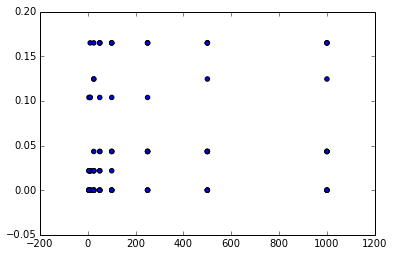

In [36]:
plt.scatter(costs_all.rp.astype(float),costs_all.missingroutes.astype(float)/len(baseline))

In [38]:
costs_all.ix[costs_all.cluster=="americana",\
             ["ruc_increase","missingroutes","num_aff_routes","cost_with_traffic","km_diff"]].astype(float).describe()

,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
count,32.000000,32,32.000000,32.000000,32.000000
mean,314.269719,0,1702.000000,2170346.679329,192.470322
std,141.259576,0,553.263164,975538.634418,90.850860
min,0.759992,0,264.000000,5248.506913,-0.001999
25%,308.861790,0,1874.000000,2132999.518764,178.854094
50%,390.248743,0,1874.000000,2695057.819656,230.066046
75%,397.519750,0,1946.000000,2745271.392076,230.978773
max,402.584307,0,1946.000000,2780247.222557,289.799531


In [39]:
costs_all.ix[costs_all.cluster=="central",\
             ["ruc_increase","missingroutes","num_aff_routes","cost_with_traffic","km_diff"]].astype(float).describe()

,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,35.655418,275.062500,1523.250000,151357.248917,22.037636
std,10.722454,101.593414,245.609577,45516.818960,6.102547
min,10.602469,0.000000,1190.000000,45007.480769,2.843182
25%,27.479344,180.000000,1252.000000,116649.814486,19.091821
50%,31.504414,359.000000,1571.000000,133736.236524,19.939834
75%,42.897966,359.000000,1726.000000,182101.864438,26.169784
max,65.873022,359.000000,1890.000000,279630.979908,32.620210


In [40]:
costs_all.ix[costs_all.cluster=="norte",\
             ["ruc_increase","missingroutes","num_aff_routes","cost_with_traffic","km_diff"]].astype(float).describe()

,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,124.788318,1015.812500,961.062500,743863.164993,76.565422
std,195.502448,488.271965,383.575365,1165390.090546,117.778077
min,0.825384,0.000000,174.000000,4920.116762,-0.110638
25%,5.294856,860.000000,634.000000,31562.637852,0.165497
50%,55.649004,1366.000000,828.000000,331723.709879,39.590298
75%,56.241143,1366.000000,1264.000000,335253.452930,39.590298
max,521.949188,1366.000000,1788.000000,3111339.109435,314.828905


In [43]:
sel = (costs_all.cluster=="americana")&(costs_all.rp=='1000')
costs_all.ix[sel,:]

,model,cluster,rp,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
2,EU_Watch,americana,1000,402.5843,0,1946,2780247,289.7995
26,GFDL,americana,1000,397.5197,0,1874,2745271,230.9788
50,HadGEM2,americana,1000,307.9472,0,1946,2126684,178.8447
74,IPSL,americana,1000,309.6123,0,1946,2138182,178.8572


In [44]:
sel = (costs_all.cluster=="central")&(costs_all.rp=='1000')
costs_all.ix[sel,:]

,model,cluster,rp,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
10,EU_Watch,central,1000,47.75862,359,1726,202735.3,29.82124
34,GFDL,central,1000,47.75862,359,1726,202735.3,29.82124
58,HadGEM2,central,1000,29.89781,359,1252,126916.2,22.56172
82,IPSL,central,1000,31.55837,359,1726,133965.3,19.74644


In [45]:
sel = (costs_all.cluster=="norte")&(costs_all.rp=='1000')
costs_all.ix[sel,:]

,model,cluster,rp,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
18,EU_Watch,norte,1000,521.9492,1366,1264,3111339,314.8289
42,GFDL,norte,1000,55.649,1366,634,331723.7,39.5903
66,HadGEM2,norte,1000,56.24114,1366,634,335253.5,39.5903
90,IPSL,norte,1000,43.1723,1031,772,257350.1,29.14604
